## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [162]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

# disable python warnings
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [212]:
## Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
# from models import Net
from models_nopool import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2))
  (conv1_bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_drop): Dropout(p=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv2_bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (conv3_bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_drop): Dropout(p=0.3)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
  (conv4_bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_drop): Dropout(p=0.4)
  (fc1): Linear(in_features=36864, out_features=4096, bias=True)
  (fc1_bn1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_drop): Dropout(p=0.5)
  (fc2): Linear(in_features=4096, out_features=2048, b

In [259]:
# Check weights and bias
print(net.fc1.weight.data)

tensor([[ 0.0024, -0.0073,  0.0001,  ...,  0.0006, -0.0014, -0.0033],
        [-0.0039, -0.0100, -0.0065,  ...,  0.0064,  0.0020,  0.0048],
        [-0.0013, -0.0022,  0.0039,  ..., -0.0021,  0.0012,  0.0170],
        ...,
        [ 0.0047,  0.0049, -0.0047,  ...,  0.0090,  0.0019, -0.0093],
        [ 0.0029,  0.0050, -0.0061,  ...,  0.0015,  0.0001,  0.0027],
        [-0.0092, -0.0014, -0.0043,  ...,  0.0045,  0.0113,  0.0024]])


In [260]:
print(net.fc1.bias.data)

tensor([0., 0., 0.,  ..., 0., 0., 0.])


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [199]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor, RandomRotate


## define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     RandomRotate(),
                                     Normalize(),
                                     ToTensor(),
                                    ])

# testing that you've defined a transform
assert(train_transform is not None), 'Define a data_transform'

In [200]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)

print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [201]:
# load training data in batches
batch_size = 64

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [202]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above


# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                      root_dir='data/test/',
                                      transform=data_transform)

In [203]:
# load test data in batches
batch_size = 64

test_loader = DataLoader(test_dataset, 
                         batch_size=batch_size,
                         shuffle=True, 
                         num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [204]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [177]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts= net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])
torch.Size([64, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [178]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

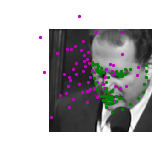

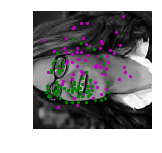

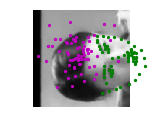

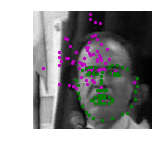

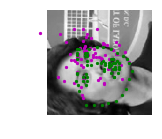

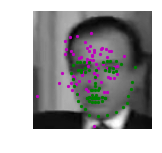

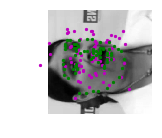

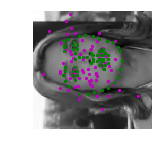

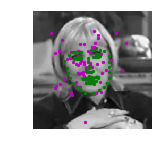

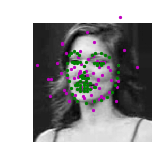

In [179]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(25,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
        
        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100    
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i] 
            ground_truth_pts = ground_truth_pts*50.0+100
            
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [205]:
## Define the loss and optimization
import torch.optim as optim

#criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()

#optimizer = optim.RMSprop(net.parameters(), lr=0.01)
optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [206]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

            
    print('Finished Training')


### Model without maxpooling layer

#### epoch 1- 50 (no pooling model)

In [182]:
# train your network
n_epochs = 50 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.003694048285484314
Epoch: 1, Batch: 20, Avg. Loss: 0.0028776150941848756
Epoch: 1, Batch: 30, Avg. Loss: 0.002544719487428665
Epoch: 1, Batch: 40, Avg. Loss: 0.002290105149149895
Epoch: 1, Batch: 50, Avg. Loss: 0.0021207869946956634
Epoch: 2, Batch: 10, Avg. Loss: 0.0021983767300844193
Epoch: 2, Batch: 20, Avg. Loss: 0.002136929839849472
Epoch: 2, Batch: 30, Avg. Loss: 0.0019519773423671723
Epoch: 2, Batch: 40, Avg. Loss: 0.0019053548723459244
Epoch: 2, Batch: 50, Avg. Loss: 0.0018375253826379775
Epoch: 3, Batch: 10, Avg. Loss: 0.0019940247982740402
Epoch: 3, Batch: 20, Avg. Loss: 0.0018024266064167022
Epoch: 3, Batch: 30, Avg. Loss: 0.0017818973809480667
Epoch: 3, Batch: 40, Avg. Loss: 0.0017627004832029343
Epoch: 3, Batch: 50, Avg. Loss: 0.0016630536019802094
Epoch: 4, Batch: 10, Avg. Loss: 0.0017248121947050095
Epoch: 4, Batch: 20, Avg. Loss: 0.001614212840795517
Epoch: 4, Batch: 30, Avg. Loss: 0.0015554816126823426
Epoch: 4, Batch: 40, Avg. Loss: 0

Epoch: 31, Batch: 10, Avg. Loss: 0.00035251840762794015
Epoch: 31, Batch: 20, Avg. Loss: 0.00035248211584985254
Epoch: 31, Batch: 30, Avg. Loss: 0.00040012495778501034
Epoch: 31, Batch: 40, Avg. Loss: 0.0003560098968446255
Epoch: 31, Batch: 50, Avg. Loss: 0.0003455151841044426
Epoch: 32, Batch: 10, Avg. Loss: 0.0003552625719457865
Epoch: 32, Batch: 20, Avg. Loss: 0.0003854248709976673
Epoch: 32, Batch: 30, Avg. Loss: 0.000360619705170393
Epoch: 32, Batch: 40, Avg. Loss: 0.00037867046892642976
Epoch: 32, Batch: 50, Avg. Loss: 0.00033844707906246184
Epoch: 33, Batch: 10, Avg. Loss: 0.00041723406687378884
Epoch: 33, Batch: 20, Avg. Loss: 0.0004113984201103449
Epoch: 33, Batch: 30, Avg. Loss: 0.00038602781109511853
Epoch: 33, Batch: 40, Avg. Loss: 0.0003722281362861395
Epoch: 33, Batch: 50, Avg. Loss: 0.0003568762969225645
Epoch: 34, Batch: 10, Avg. Loss: 0.00045477786660194397
Epoch: 34, Batch: 20, Avg. Loss: 0.0003472025953233242
Epoch: 34, Batch: 30, Avg. Loss: 0.0004012086149305105
Epo

#### epoch 51- 100((no pooling model)

In [185]:
n_epochs = 50 

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.00039019208773970605
Epoch: 1, Batch: 20, Avg. Loss: 0.00037446342036128046
Epoch: 1, Batch: 30, Avg. Loss: 0.00036900376342236993
Epoch: 1, Batch: 40, Avg. Loss: 0.00031122629716992376
Epoch: 1, Batch: 50, Avg. Loss: 0.00034326581098139287
Epoch: 2, Batch: 10, Avg. Loss: 0.00031002358347177506
Epoch: 2, Batch: 20, Avg. Loss: 0.000364991994574666
Epoch: 2, Batch: 30, Avg. Loss: 0.0002914524879306555
Epoch: 2, Batch: 40, Avg. Loss: 0.0003076639827340841
Epoch: 2, Batch: 50, Avg. Loss: 0.00028387458063662053
Epoch: 3, Batch: 10, Avg. Loss: 0.00039653694443404677
Epoch: 3, Batch: 20, Avg. Loss: 0.0002844503615051508
Epoch: 3, Batch: 30, Avg. Loss: 0.0002900459337979555
Epoch: 3, Batch: 40, Avg. Loss: 0.0002845101673156023
Epoch: 3, Batch: 50, Avg. Loss: 0.00028294153697788716
Epoch: 4, Batch: 10, Avg. Loss: 0.00025932716764509676
Epoch: 4, Batch: 20, Avg. Loss: 0.0002781024109572172
Epoch: 4, Batch: 30, Avg. Loss: 0.0002985871136188507
Epoch: 4, Batch: 40

Epoch: 30, Batch: 50, Avg. Loss: 0.00023238888755440712
Epoch: 31, Batch: 10, Avg. Loss: 0.00028378944285213946
Epoch: 31, Batch: 20, Avg. Loss: 0.0002282336689531803
Epoch: 31, Batch: 30, Avg. Loss: 0.00022922466602176428
Epoch: 31, Batch: 40, Avg. Loss: 0.00022046191431581975
Epoch: 31, Batch: 50, Avg. Loss: 0.00023355540819466113
Epoch: 32, Batch: 10, Avg. Loss: 0.00024555974453687666
Epoch: 32, Batch: 20, Avg. Loss: 0.00021986491046845912
Epoch: 32, Batch: 30, Avg. Loss: 0.0002716754246503115
Epoch: 32, Batch: 40, Avg. Loss: 0.00023354712128639222
Epoch: 32, Batch: 50, Avg. Loss: 0.0002583275344222784
Epoch: 33, Batch: 10, Avg. Loss: 0.00023240363970398903
Epoch: 33, Batch: 20, Avg. Loss: 0.0002293083779513836
Epoch: 33, Batch: 30, Avg. Loss: 0.00022287279833108187
Epoch: 33, Batch: 40, Avg. Loss: 0.00029319377802312376
Epoch: 33, Batch: 50, Avg. Loss: 0.00024342595785856248
Epoch: 34, Batch: 10, Avg. Loss: 0.0002607794441282749
Epoch: 34, Batch: 20, Avg. Loss: 0.000249649863690137

#### epoch 101- 150((no pooling model)

In [189]:
n_epochs = 50 

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.00021083949506282807
Epoch: 1, Batch: 20, Avg. Loss: 0.0002933135526254773
Epoch: 1, Batch: 30, Avg. Loss: 0.00022353902272880078
Epoch: 1, Batch: 40, Avg. Loss: 0.00018320547509938478
Epoch: 1, Batch: 50, Avg. Loss: 0.0002431455347687006
Epoch: 2, Batch: 10, Avg. Loss: 0.0002384464517235756
Epoch: 2, Batch: 20, Avg. Loss: 0.00019800971262156963
Epoch: 2, Batch: 30, Avg. Loss: 0.00020271704997867345
Epoch: 2, Batch: 40, Avg. Loss: 0.00021195672452449797
Epoch: 2, Batch: 50, Avg. Loss: 0.0002110354695469141
Epoch: 3, Batch: 10, Avg. Loss: 0.00020040985848754643
Epoch: 3, Batch: 20, Avg. Loss: 0.00024251857586205005
Epoch: 3, Batch: 30, Avg. Loss: 0.00021731439419090748
Epoch: 3, Batch: 40, Avg. Loss: 0.00019905963633209468
Epoch: 3, Batch: 50, Avg. Loss: 0.0001848064884543419
Epoch: 4, Batch: 10, Avg. Loss: 0.0002679378669708967
Epoch: 4, Batch: 20, Avg. Loss: 0.00019390195794403552
Epoch: 4, Batch: 30, Avg. Loss: 0.00020317451376467943
Epoch: 4, Batch:

Epoch: 30, Batch: 50, Avg. Loss: 0.00018935675080865622
Epoch: 31, Batch: 10, Avg. Loss: 0.00026076874136924744
Epoch: 31, Batch: 20, Avg. Loss: 0.00023051875829696656
Epoch: 31, Batch: 30, Avg. Loss: 0.0001978316158056259
Epoch: 31, Batch: 40, Avg. Loss: 0.0001855439580976963
Epoch: 31, Batch: 50, Avg. Loss: 0.0002189509626477957
Epoch: 32, Batch: 10, Avg. Loss: 0.00019547482300549744
Epoch: 32, Batch: 20, Avg. Loss: 0.00019879746250808238
Epoch: 32, Batch: 30, Avg. Loss: 0.00023887387104332448
Epoch: 32, Batch: 40, Avg. Loss: 0.0001779769193381071
Epoch: 32, Batch: 50, Avg. Loss: 0.00020225012674927713
Epoch: 33, Batch: 10, Avg. Loss: 0.00020870521012693644
Epoch: 33, Batch: 20, Avg. Loss: 0.0002560139847919345
Epoch: 33, Batch: 30, Avg. Loss: 0.00019541628751903773
Epoch: 33, Batch: 40, Avg. Loss: 0.0001854781899601221
Epoch: 33, Batch: 50, Avg. Loss: 0.00016277247481048107
Epoch: 34, Batch: 10, Avg. Loss: 0.00019234158284962176
Epoch: 34, Batch: 20, Avg. Loss: 0.0001961207240819931

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [194]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])
torch.Size([64, 68, 2])


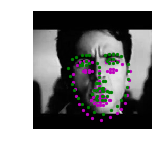

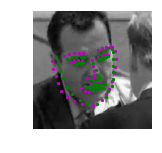

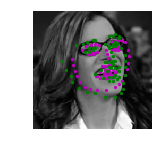

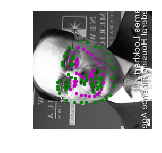

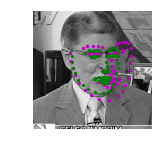

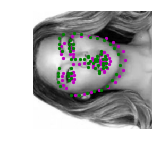

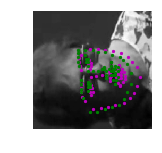

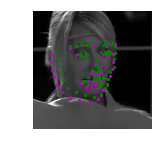

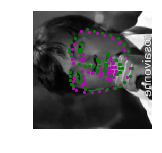

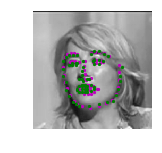

In [195]:
## visualize your test output

visualize_output(test_images, test_outputs, gt_pts)

Once you've found a good model (or two), save your model so you can load it and use it later!

In [196]:
## change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_nopool_150.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: 

Use Adam optimizer and SmoothL1 loss function. As for optimizer, Adam worked better than SGD based on test result.
SmoothL1 loss function reached lower average loss quicker than MSE loss function.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: 

I started with five convolutional layers followed by three fully connected layers. Although the average loss decreased substantially, the test result was poor. It showed that similar predict keypoints were displayed in different facial poses. It might be overfit the data. Therefore, I decided to remove one convolutional layer to avoid overfitting. It performed better than five convolutional layers but the training process was still slow. According to 
[this paper](https://arxiv.org/pdf/1412.6806.pdf), replace maxpooling layers by a convolutional layer with increased stride, it can outperform alternating convolution and max-pooling layers. I removed all the maxpooling layers in four convolutional layers and increased the stride to 2. By this way, the network could be trained quicker and the loss was dropped as training epochs went on. 


- lst try: five convolutional layers + three fully connected layers

|Layer Name | Layer Shape  |
|------|------|
|   input  | 1, 224, 224|
|   conv1 | 32, 220, 220|
|   conv1_bn1 | 32, 220, 220|
|   relu activation | 32, 220, 220|
|   maxPool2d | 32, 110, 110|
|   conv1_drop(p=0.1) | 32, 110, 110|
|   conv2 | 64, 108, 108|
|   conv2_bn2 | 64, 108, 108|
|   relu activation | 64, 108, 108|
|   maxPool2d | 64, 54, 54|
|   conv2_drop(p=0.2) | 64, 54, 54|
|   conv3 | 128, 52, 52|
|   conv3_bn3 | 128, 52, 52|
|   relu activation | 128, 52, 52|
|   maxPool2d | 128, 26, 26|
|   conv3_drop(p=0.3) | 128, 26, 26|
|   conv4 | 256, 24, 24|
|   conv4_bn4 | 256, 24, 24|
|   relu activation | 256, 24, 24|
|   maxPool2d | 256, 12, 12|
|   conv4_drop(p=0.4) | 256, 12, 12|
|   conv5 | 512, 12, 12|
|   conv5_bn5 | 512, 12, 12|
|   relu activation | 512, 12, 12|
|   maxPool2d | 512, 6, 6|
|   conv5_drop(p=0.5) | 512, 6, 6|
|   fc1 | 4096|
|   fc1_bn1 | 4096|
|   relu activation | 4096|
|   fc1_drop(p=0.5) | 4096|
|   fc2 | 2048|
|   fc2_bn2 | 2048|
|   relu activation | 2048|
|   fc2_drop(p=0.5) | 2048|
|   fc3 | 136|




- 2nd try: four convolutional layers + three fully connected layers

|Layer Name | Layer Shape  |
|------|------|
|   input  | 1, 224, 224|
|   conv1 | 32, 220, 220|
|   conv1_bn1 | 32, 220, 220|
|   relu activation | 32, 220, 220|
|   maxPool2d | 32, 110, 110|
|   conv1_drop(p=0.1) | 32, 110, 110|
|   conv2 | 64, 108, 108|
|   conv2_bn2 | 64, 108, 108|
|   relu activation | 64, 108, 108|
|   maxPool2d | 64, 54, 54|
|   conv2_drop(p=0.2) | 64, 54, 54|
|   conv3 | 128, 52, 52|
|   conv3_bn3 | 128, 52, 52|
|   relu activation | 128, 52, 52|
|   maxPool2d | 128, 26, 26|
|   conv3_drop(p=0.3) | 128, 26, 26|
|   conv4 | 256, 24, 24|
|   conv4_bn4 | 256, 24, 24|
|   relu activation | 256, 24, 24|
|   maxPool2d | 256, 12, 12|
|   conv4_drop(p=0.4) | 256, 12, 12|
|   fc1 | 4096|
|   fc1_bn1 | 4096|
|   relu activation | 4096|
|   fc1_drop(p=0.5) | 4096|
|   fc2 | 2048|
|   fc2_bn2 | 2048|
|   relu activation | 2048|
|   fc2_drop(p=0.5) | 2048|
|   fc3 | 136|


- 3rd try(final model): four convolutional layers w/o maxpooling layers + three fully connected layers

|Layer Name | Layer Shape  |
|------|------|
|   input  | 1, 224, 224|
|   conv1(stride =2) | 32, 110, 110|
|   conv1_bn1 | 32, 110, 110|
|   relu activation | 32, 110, 110|
|   conv1_drop(p=0.1) | 32, 110, 110|
|   conv2(stride =2)  | 64, 54, 54|
|   conv2_bn2 | 64, 54, 54|
|   relu activation | 64, 54, 54|
|   conv2_drop(p=0.2) | 64, 54, 54|
|   conv3(stride =2)  | 128, 26, 26|
|   conv3_bn3 | 128, 26, 26|
|   relu activation | 128, 26, 26|
|   conv3_drop(p=0.3) | 128, 26, 26|
|   conv4(stride =2)  | 256, 12, 12|
|   conv4_bn4 | 256, 12, 12|
|   relu activation | 256, 12, 12|
|   conv4_drop(p=0.4) | 256, 12, 12|
|   fc1 | 4096|
|   fc1_bn1 | 4096|
|   relu activation | 4096|
|   fc1_drop(p=0.5) | 4096|
|   fc2 | 2048|
|   fc2_bn2 | 2048|
|   relu activation | 2048|
|   fc2_drop(p=0.5) | 2048|
|   fc3 | 136|


### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: 

I ran the notebooks on my CPU computer, so I choose smaller batch_size to train the model. When I used the batch_size, 128, it showed that my CPU utilization was running out. Therefore, I decreased the batch_size to 64, it worked great and the average loss was dropped consistently until 100 epochs. As I extended the epoch to 150, the loss dropped slightly and stuck around loss of 0.0002. Thus, I stop the training.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

First convolutional layer
Filter shape (5, 5)


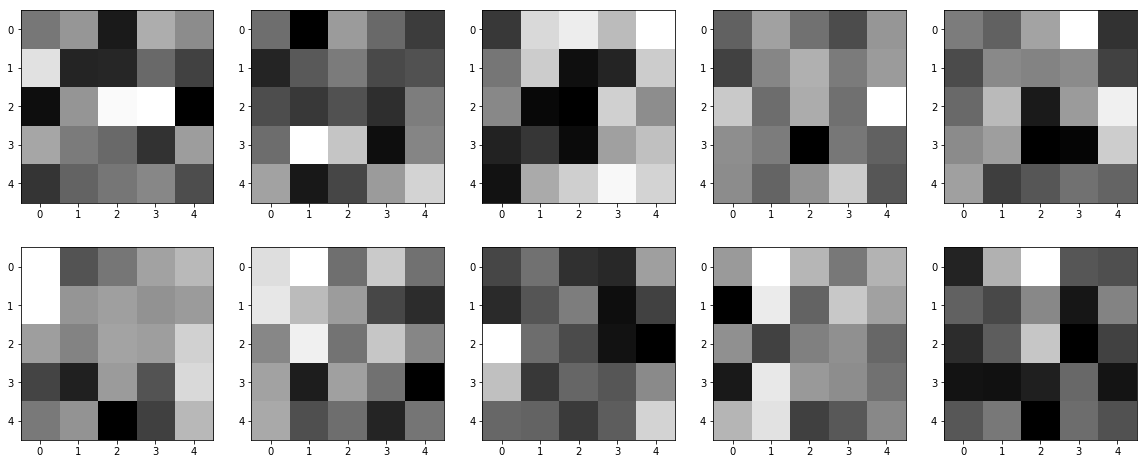

In [213]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data
w = weights1.numpy()

# for first 10 filters
fig = plt.figure(figsize=(20,8))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')

print('First convolutional layer')
print('Filter shape', w[0][0].shape)
plt.show()

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

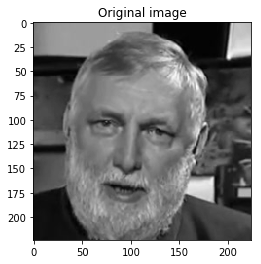

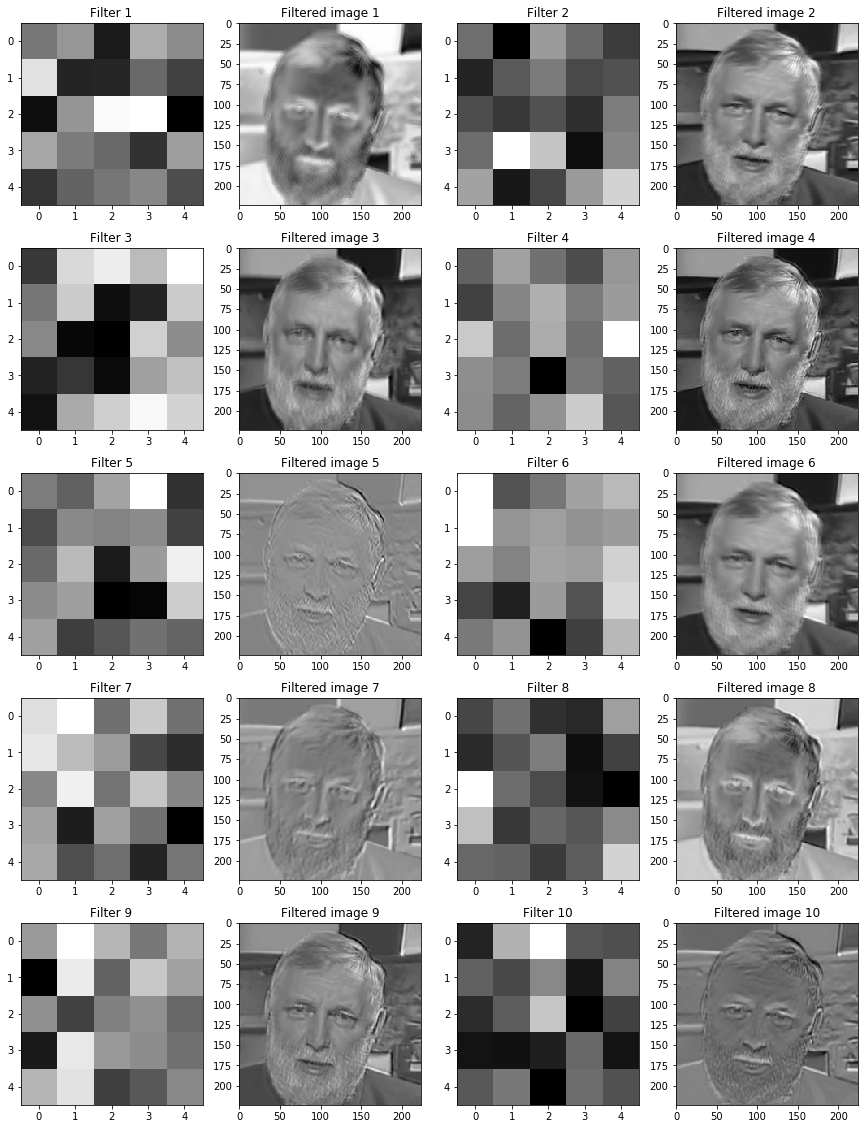

In [236]:
## load in and display any image from the transformed test dataset
import cv2
idx = 12
# un-transform the image data
image = test_images[idx].data   # get the image from it's wrapper
image = image.numpy() # convert to numpy array from a Tensor
image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
image = np.squeeze(image)
plt.imshow(image, cmap='gray')
plt.title('Original image')

## Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
fig = plt.figure(figsize=(15,20))
columns = 4
rows = 5
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
        plt.title('Filter ' + str(i//2 + 1))
    else:
        c = cv2.filter2D(image, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
        plt.title('Filtered image ' + str(i//2 + 1))
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


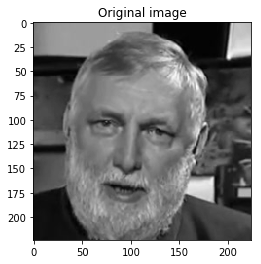

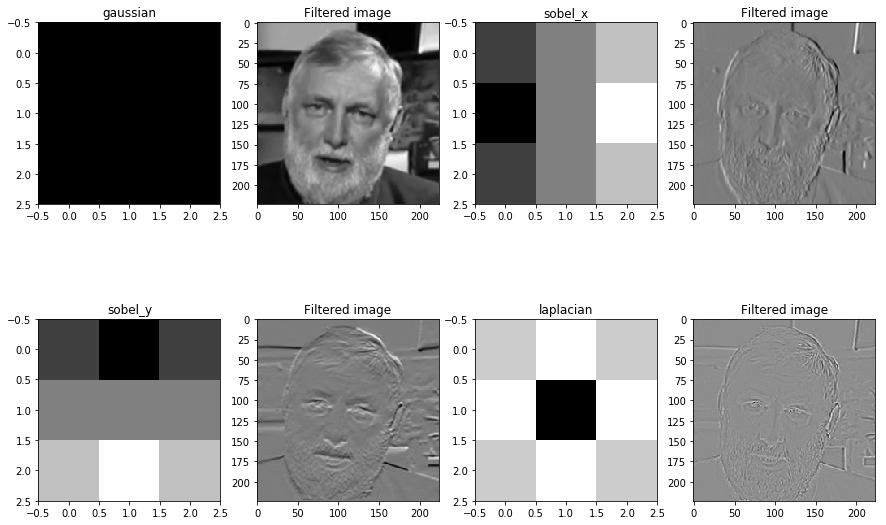

In [256]:
idx = 12
# un-transform the image data
image = test_images[idx].data   # get the image from it's wrapper
image = image.numpy() # convert to numpy array from a Tensor
image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
image = np.squeeze(image)
plt.imshow(image, cmap='gray')
plt.title('Original image')

# common filters
# blur and smooth images
gaussian = (1/9)*np.array([[1, 1, 1],
                           [1, 1, 1],
                           [1, 1, 1]])

# detect vertical lines
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

# detect horizontal lines
sobel_y = np.array([[-1, -2, -1],
                    [ 0, 0, 0],
                    [ 1, 2, 1]])

# detect edges
laplacian = np.array([[0,  1, 0],
                      [1, -4, 1],
                      [0,  1, 0]])



filters = [gaussian, sobel_x, sobel_y, laplacian]
filter_names = ['gaussian', 'sobel_x', 'sobel_y', 'laplacian']

## Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
fig = plt.figure(figsize=(15,10))
columns = 4
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if((i%2)==0):
        plt.imshow(filters[i//2], cmap='gray')
        plt.title(filter_names[i//2])
    else:
        c = cv2.filter2D(image, -1, filters[i//2])
        plt.imshow(c, cmap='gray')
        plt.title('Filtered image')
plt.show()

**Answer**: 

I compared the first ten filters in the first convolutional layer with some common filters, gaussian, sobel_x, sobel_y and laplacian filters, in order to get better idea what kind of features were detected in each filter.

The kernels in our filters are quite random, so it is hard to identify whether if the filter is used to for a specific feature such as detecting vertical lines or horizontal lines. In filter 1 and 8, it increased the contrast of the grayscale image. In filter 2, 4 and 6, it blured the images. The rest of filters made the output images shown in different level of gradient in both of x and y directions, so it detected edges.


---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!